# Covid-19: From model prediction to model predictive control

## Scenario-analysis with the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
# Load interaction matrices
Nc_home = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELhome.txt", dtype='f', delimiter='\t')
Nc_work = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELwork.txt", dtype='f', delimiter='\t')
Nc_schools = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELschools.txt", dtype='f', delimiter='\t')
Nc_transport = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELtransport.txt", dtype='f', delimiter='\t')
Nc_leisure = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELleisure.txt", dtype='f', delimiter='\t')
Nc_others = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELothers.txt", dtype='f', delimiter='\t')
Nc_total = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELtotal.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("../../data/raw/Interaction_matrices/Belgium/BELagedist_10year.txt", dtype='f', delimiter='\t')

### Initialise model

In [3]:
h = np.array([[0.0205,0.0205,0.1755,0.1755,0.2115,0.2503,0.3066,0.4033,0.4770]])
icu = np.array([0,0,0.0310,0.0310,0.055,0.077,0.107,0.1685,0.1895])
r = icu/h

In [4]:
model = models.SEIRSAgeModel(initN   = initN,         #16x0 numpy array
                                     beta    = 0.0622, # probability of infection when encountering infected person
                                     sigma   = 3.2, # latent period
                                     omega   = 2.0, # pre-symptomatic infectious period
                                     Nc = Nc_total, #must be a numpy array; average number of human-to-human interactions per day
                                     a = 0.43, # probability of an asymptotic (supermild) infection
                                     m = 1-0.43, # probability of a mild infection
                                     h = h, # probability of hospitalisation for a mild infection
                                     c = 1-r, # probability of hospitalisation in cohort
                                     mi = 0.5*r, # probability of hospitalisation in midcare
                                     da = 7, # days of infection when asymptomatic (supermild)
                                     dm = 7, # days of infection when mild
                                     dc = 6.5,
                                     dmi = 8,
                                     dICU = 8,
                                     dICUrec = 6.5,
                                     dmirec = 6.5,
                                     dhospital = 7.5, # days before reaching the hospital when heavy or critical
                                     #m0 = np.transpose(np.array([0.000094,0.00022,0.00091,0.0018,0.004,0.013,0.046,0.098,0.18])), # mortality in ICU
                                     m0 = np.ones(9)*0.50,
                                     maxICU = 2000,
                                     totalTests = 0,
                                     psi_FP = 0, # probability of a false positive
                                     psi_PP = 1, # probability of a correct test
                                     dq = 14, # days in quarantaine                          
                                     initE = np.array([1,1,1,1,1,0,0,0,0]), # virus was most likely 'imported' by skiers, assume max. age 50 years
                                     initI = np.zeros(9),
                                     initA = np.zeros(9), 
                                     initM = np.zeros(9),
                                     initC = np.zeros(9),
                                     initCmirec = np.zeros(9),
                                     initCicurec = np.zeros(9),
                                     initMi = np.zeros(9),
                                     initICU = np.zeros(9),
                                     initR = np.zeros(9),
                                     initD = np.zeros(9),
                                     initSQ = np.zeros(9),
                                     initEQ = np.zeros(9),
                                     initIQ = np.zeros(9),
                                     initAQ = np.zeros(9),
                                     initMQ = np.zeros(9),
                                     initRQ = np.zeros(9),
                                     monteCarlo = False,
                                     n_samples = 1,
                            )

### Scrape high-level Sciensano data

In [5]:
[index,data] = models.obtainData()
ICUvect = np.transpose(data[0])
hospital = np.transpose(data[1])
print(ICUvect.shape)

(1, 65)


### Perform calibration

In [14]:
# vector with dates
index=pd.date_range('2020-03-15', freq='D', periods=ICUvect.size)
# data series used to calibrate model must be given to function 'plotFit' as a list
idx = -56
index = index[0:idx]
data=[np.transpose(ICUvect[:,0:idx]),np.transpose(hospital[:,0:idx])]
# set optimisation settings
parNames = ['beta'] # must be a list!
positions = [np.array([5,6]),np.array([4,5,6])] # must be a list!
bounds=((10,100),(0.01,0.12)) # must be a list!
weights = np.array([0,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,setvar=True,maxiter=30,popsize=120)

No constraints given.
Best after iteration 1: [8.36426999e+01 2.60604933e-02] 860405.5743861411
New best for swarm at iteration 2: [33.57133208  0.06369754] 158541.559014292
Best after iteration 2: [33.57133208  0.06369754] 158541.559014292
Best after iteration 3: [33.57133208  0.06369754] 158541.559014292
New best for swarm at iteration 4: [39.77236881  0.05223287] 78964.28198428593
Best after iteration 4: [39.77236881  0.05223287] 78964.28198428593
New best for swarm at iteration 5: [44.445336    0.04598921] 65873.40914070614
Best after iteration 5: [44.445336    0.04598921] 65873.40914070614
Best after iteration 6: [44.445336    0.04598921] 65873.40914070614
New best for swarm at iteration 7: [40.04615812  0.05111393] 42095.623799762325
Best after iteration 7: [40.04615812  0.05111393] 42095.623799762325
Best after iteration 8: [40.04615812  0.05111393] 42095.623799762325
Best after iteration 9: [40.04615812  0.05111393] 42095.623799762325
Best after iteration 10: [40.04615812  0.05

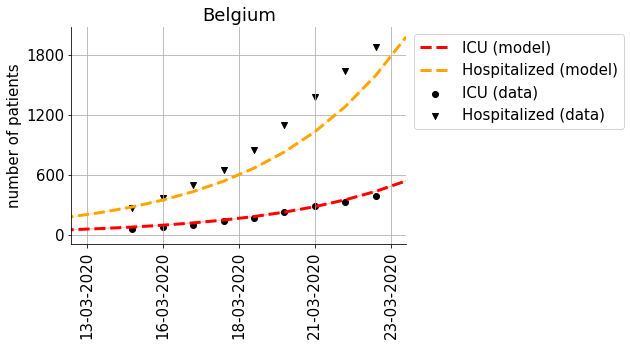

In [15]:
# plot result
model.plotFit(index,data,positions,modelClr=['red','orange'],legendText=('ICU (model)','Hospitalized (model)','ICU (data)','Hospitalized (data)'),titleText='Belgium')

Slight underestimation of hospitalizations, most likely due to the fact that residence times in the hospital differ from the values used in our model. Using the UZ Ghent data to estimate distributions and incorporating this uncertainty will surely fix this in the future.

Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [164]:
# Define data as a list containing data timeseries
data=[np.transpose(ICUvect),np.transpose(hospital)]
# vector with dates
index=pd.date_range('2020-03-15', freq='D', periods=ICUvect.size)
print(index[2],index[50],index[57],index[-1])

2020-03-17 00:00:00 2020-05-04 00:00:00 2020-05-11 00:00:00 2020-05-18 00:00:00


The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [179]:
sigma1 = 0.1
sigma2 = 0.2 # rule of four
sigma3 = 0.4 # Arbitrary increase after further relaxing of measures on June 4th

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

<img src="../../docs/_static/figs/retailGoogleReport.png" alt="drawing" width="400"/>

<img src="../../docs/_static/figs/workGoogleReport.png" alt="drawing" width="400"/>

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [184]:
# Create a dictionary of past policies
pastPolicy = {'t':       [8,50,57], 
              'Nc':      [0.5*Nc_home+sigma1*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          # 70 percent reduction in work --> from data gert peersman,
                          # 70 percent reduction in transit --> google community mobility report
                          0.5*Nc_home+sigma2*((1-0.40)*Nc_work+(1-0.50)*Nc_transport),
                          # rule of four: sigma increases
                          # 40 percent reduction in work --> google covid mobility reports
                          # 50 percent reduction in transit --> google covid mobility reports (Contact Koen Schoors for data De Lijn!)
                          0.5*Nc_home+sigma2*((1-0.30)*Nc_work+(1-0.45)*Nc_transport+(1-0.50)*Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 30 percent reduction in work --> Google
                          # 45 percent reduction in transit --> Google
                          # All ages up untill 12 years back to school --> roughly 50 percent of schools back open
                          # retail & recreation back to 40 percent --> Google mobility report --> assume both leisure and others
                         ]
              }

In [185]:
# Create a dictionary of future policies
futurePolicy = {'t':     [3,18], # May 21th, June 4th 
                'Nc':    [0.5*Nc_home+sigma2*((1-0.20)*Nc_work+(1-0.40)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 20 percent reduction in work --> If current trend in Google reports persists
                          # 40 percent reduction in transit --> If current trend in Google reports persists
                          # All ages back to school --> a lot of media attention to re-open schools at this point...
                          # retail & recreation still at 40 percent --> Google mobility report --> maybe it's going more up
                          0.5*Nc_home+sigma3*((1-0.20)*Nc_work+(1-0.50)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others)
                          # Phase 3 of lockdown release: will we be able to see more friends? Increase in sigma.
                          # From hereon: scenarios
                         ],
              }

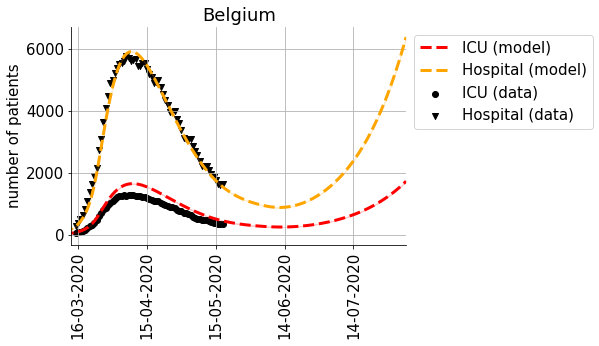

In [186]:
# Define the date corresponding to the first data entry
startDate='2020-03-15'
# Run realTimeScenario
model.realTimeScenario(startDate,data,positions,pastPolicy,futurePolicy=futurePolicy,T_extra=62,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')